# Final Report: Diagnosing Heart Disease

Cardiovascular disease is the leading cause of death worldwide (Ahmad & Anderson, 2021). During 2020, the United States saw 690,882 deaths from this condition, compared to the 345,323 deaths from COVID-19 (Centre of Disease Control and Prevention, 2022). There are several risk factors for developing heart disease, and the consequences of heart disease vary in severity. The risk of death increases when other comorbidities are present, including COVID-19 (Madjid et al., 2020). Because this disease affects a large amount of the population, it puts significant strain on the healthcare system.

We thus want to determine: Based on only two predictors gathered from health checkups performed by doctors, does somebody suffer from heart disease?

To answer this question, we analyze the Cleveland data file that contains 303 instances and records of basic information about the patient and multiple heart disease-related factors like blood pressure, blood sugar, heart rate, etc (Detrano, 1988). 

## Introduction

## Methods & Results

To run this section, please make sure that you have at least R version 4.0.3 and that all libraries are installed and loaded correctly.

In [1]:
# load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 12, repr.plot.height = 7) 
# Rscripts
source("../R/load_data.R")
source("../R/sub_values.R")
source("../R/average_numeric.R")
source("../R/abstraction_histogram.R")
source("../R/05-build_model.R")
# set seed to make sure our file is reproducible
set.seed(1020)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ────

In [2]:
# Load data file and set column names
path <- "../data/raw/heart_disease_data.csv"
column_names <- c("age", "sex", "chest_pain_type",
                  "resting_bp", "cholesterol", "high_blood_sugar",
                  "resting_ecg", "max_heart_rate", "exercise_pain",
                  "old_peak", "slope", "no_vessels_colored",
                  "thal", "diagnosis", "diagnosis_2")
cleveland <- load_data(path,
                        names = column_names,
                        separator = ",",
                        na_values = "?")
glimpse(cleveland)

Rows: 303
Columns: 15
$ age                <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56,…
$ sex                <fct> male, male, male, male, fem, male, fem, fem, male, …
$ chest_pain_type    <fct> angina, asympt, asympt, notang, abnang, abnang, asy…
$ resting_bp         <dbl> 145, 160, 120, 130, 130, 120, 140, 120, 130, 140, 1…
$ cholesterol        <dbl> 233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 1…
$ high_blood_sugar   <fct> TRUE, fal, fal, fal, fal, fal, fal, fal, fal, TRUE,…
$ resting_ecg        <fct> hyp, hyp, hyp, norm, hyp, norm, hyp, norm, hyp, hyp…
$ max_heart_rate     <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 1…
$ exercise_pain      <fct> fal, TRUE, TRUE, fal, fal, fal, fal, TRUE, fal, TRU…
$ old_peak           <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.1, 0…
$ slope              <fct> down, flat, flat, down, up, up, down, up, flat, dow…
$ no_vessels_colored <dbl> 0, 3, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, …
$ thal            

In [3]:
# replace values in dataframe for readability
high_blood_sugar_vec <-
    sub_values(cleveland, high_blood_sugar,
               replacement = "true", original = "TRUE")

exercise_pain_vec <-
    sub_values(cleveland, exercise_pain,
               replacement = "true", original = "TRUE")

diagnosis_vec <-
    sub_values(cleveland, diagnosis,
               replacement = "healthy", original = "buff")

cleveland <- cleveland %>%
                mutate(high_blood_sugar = high_blood_sugar_vec,
                       exercise_pain = exercise_pain_vec,
                       diagnosis = diagnosis_vec)
cleveland

age,sex,chest_pain_type,resting_bp,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_pain,old_peak,slope,no_vessels_colored,thal,diagnosis,diagnosis_2
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0,fix,healthy,H
67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3,norm,sick,S2
67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2,rev,sick,S1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,male,notang,118,149,fal,hyp,126,fal,0.8,up,3,norm,sick,S1
74,fem,abnang,120,269,fal,hyp,121,true,0.2,up,1,norm,healthy,H
54,fem,notang,160,201,fal,norm,163,fal,0.0,up,1,norm,healthy,H


<span style="color: gray;">Table 1. Parsed Cleveland data set</span>

The column `diagnosis_2` in Table 1 distinguishes different kinds of sickness. However, we could not find any documentation about what these different classes actually mean, thus we will focus on the distinction between healthy and sick in the `diagnosis` column.

In [4]:
cleveland_select <- select(cleveland, -diagnosis_2)

cleveland_select

age,sex,chest_pain_type,resting_bp,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_pain,old_peak,slope,no_vessels_colored,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0,fix,healthy
67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3,norm,sick
67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2,rev,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,male,notang,118,149,fal,hyp,126,fal,0.8,up,3,norm,sick
74,fem,abnang,120,269,fal,hyp,121,true,0.2,up,1,norm,healthy
54,fem,notang,160,201,fal,norm,163,fal,0.0,up,1,norm,healthy


<span style="color: gray;">Table 2. Tidied Cleveland data set</span>

Having tidied the data, we now randomly split the data into a training and a testing set, taking 75% of the data for the training set.

In [5]:
split_data <- initial_split(cleveland_select, prop = 0.75, strata = diagnosis)
training_set <- training(split_data)
testing_set <- testing(split_data)

training_set

age,sex,chest_pain_type,resting_bp,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_pain,old_peak,slope,no_vessels_colored,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0,fix,healthy
41,fem,abnang,130,204,fal,hyp,172,fal,1.4,up,0,norm,healthy
56,male,abnang,120,236,fal,norm,178,fal,0.8,up,0,norm,healthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42,male,asympt,136,315,fal,norm,125,true,1.8,flat,0,fix,sick
77,male,asympt,125,304,fal,hyp,162,true,0.0,up,3,norm,sick
49,male,notang,118,149,fal,hyp,126,fal,0.8,up,3,norm,sick


<span style="color: gray;">Table 3. Cleveland training set</span>

We want to get a first impression of the different predictors in the data set, thus we compare the mean values of the numerical variables (Table 4) and the distribution of the factorial variables (Figure 1) for observations classified as sick and healthy.

In [6]:
# Average values of the numerical attributes
summary_averages <- avg_numeric(training_set, diagnosis)
summary_averages

diagnosis,age,resting_bp,cholesterol,max_heart_rate,old_peak,no_vessels_colored
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
healthy,52.32520,129.0244,241.9919,158.9431,0.5308943,0.2916667
sick,56.52427,135.0583,245.4175,138.6796,1.6708738,1.1274510


<span style="color: gray;">Table 4. Average values of the numerical attributes</span>

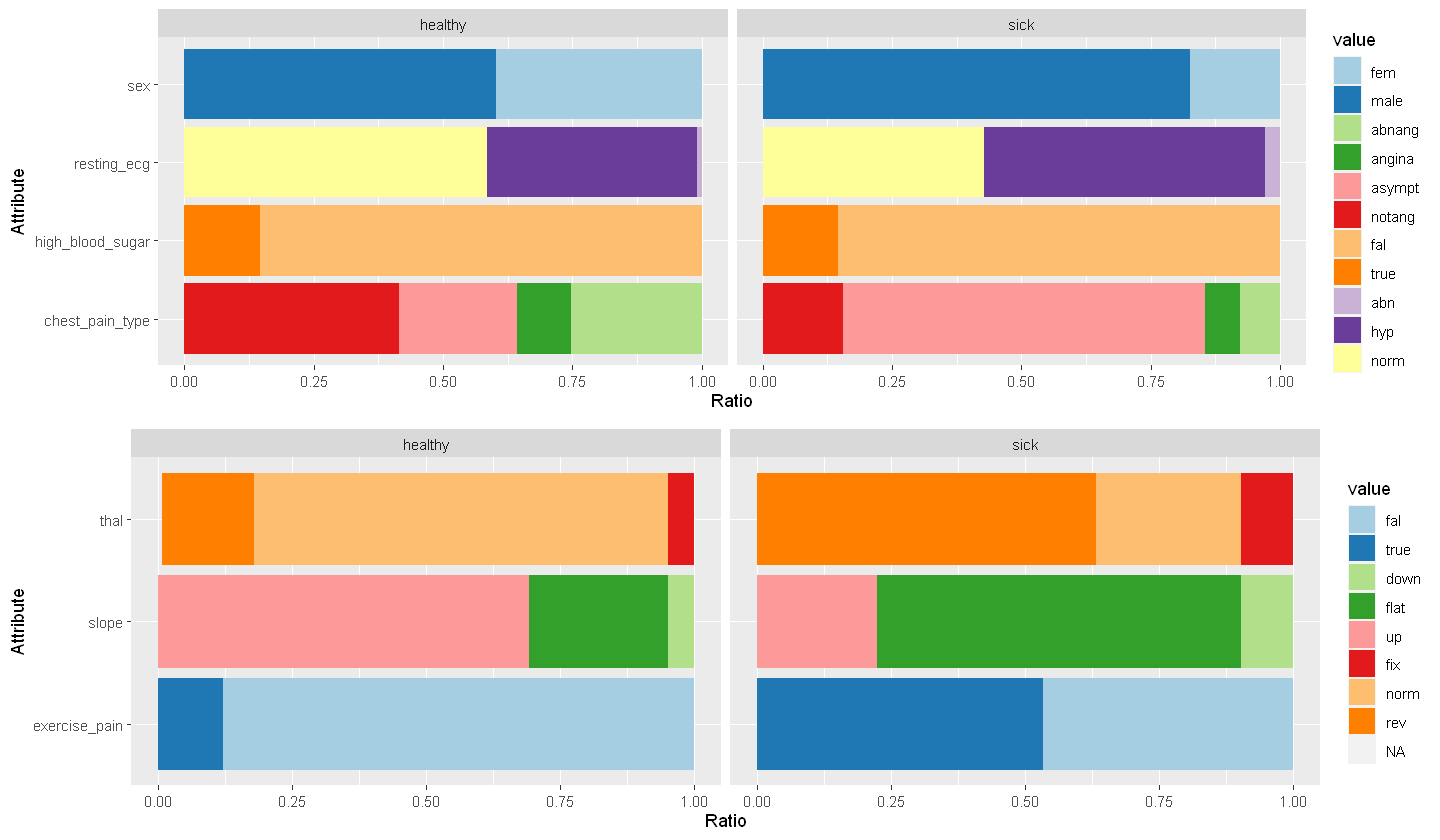

In [7]:
numeric_summary <- training_set %>%
    select(sex, chest_pain_type, high_blood_sugar,
           resting_ecg, diagnosis) %>% 
    pivot_longer(cols = sex:resting_ecg,
                 names_to = "attribute",
                 values_to = "value")

numeric_plot <- numeric_summary %>%
    ggplot() +
    aes(y = attribute, fill = value) +
    geom_bar(position = "fill") +
    facet_grid(cols = vars(diagnosis)) +
    scale_fill_brewer(palette = "Paired") +
    labs(x = "Ratio", y = "Attribute", color = "Value")

categorical_summary <- training_set %>%
    select(exercise_pain, slope, thal, diagnosis) %>%
    pivot_longer(cols = exercise_pain:thal,
                 names_to = "attribute",
                 values_to = "value")

categorical_plot <- categorical_summary %>%
    ggplot() +
    aes(y = attribute, fill = value) +
    geom_bar(position = "fill") +
    facet_grid(cols = vars(diagnosis)) +
    scale_fill_brewer(palette = "Paired") +
    labs(x = "Ratio", y = "Attribute", color = "Value")

plot_grid(numeric_plot, categorical_plot, ncol = 1)

<span style="color: gray;">Figure 1. The proportion of different values in each factorial attribute</span>

As the mean values do not tell us much about the numerical variables, we also plot their histograms to visualize the distribution of the variables (Figure 2). We will use this later to choose the predictors we want to use.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 4 rows containing non-finite values (`stat_bin()`)."


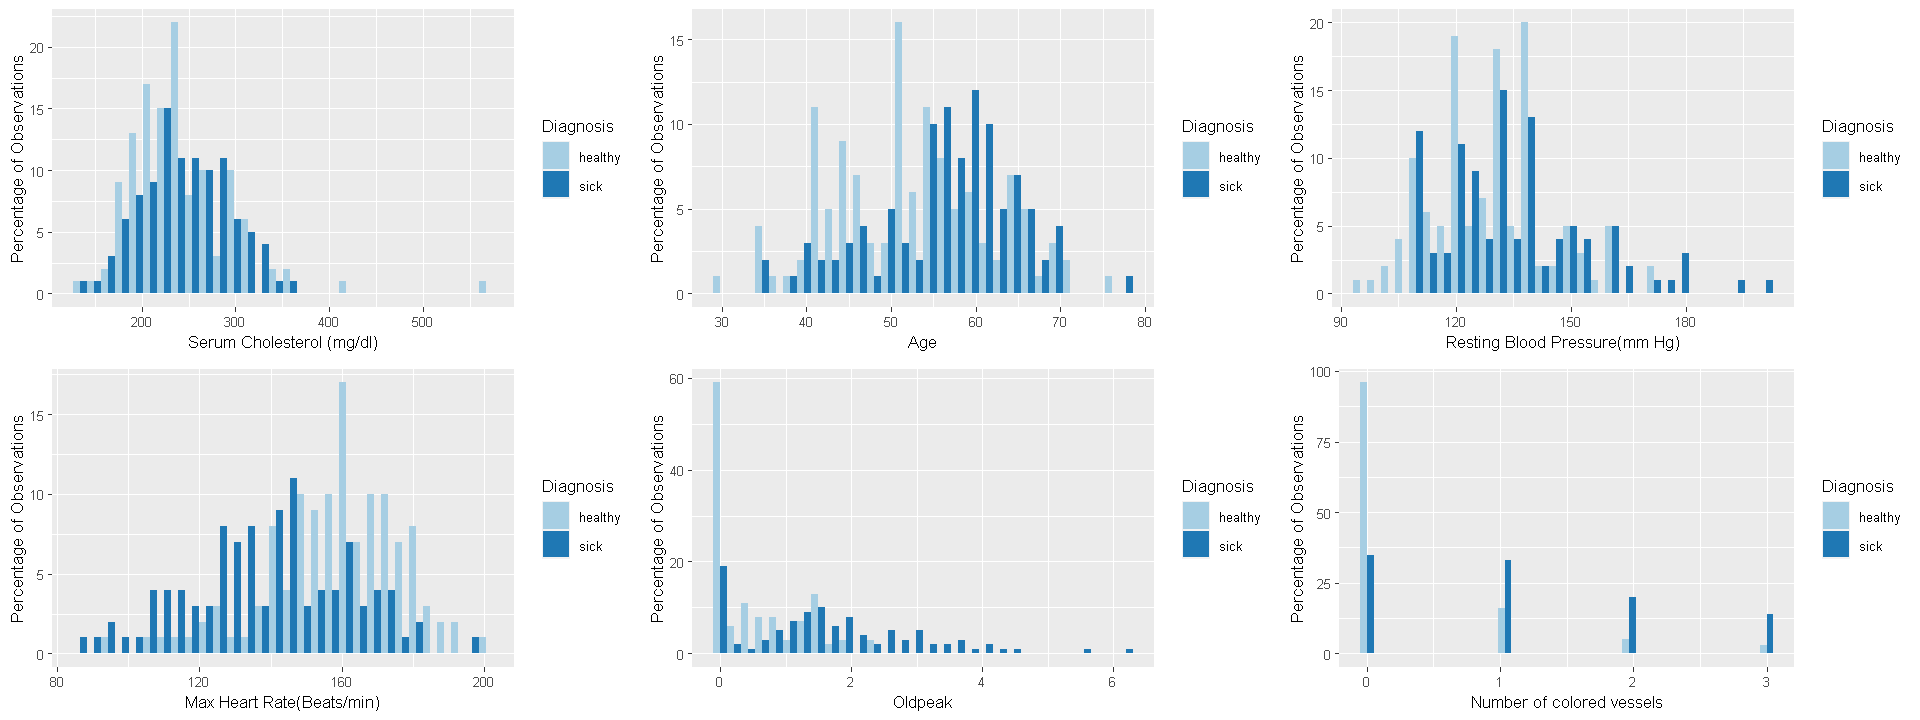

In [8]:
# Histograms for individual variables
cholesterol_histogram <-
    abs_hist(training_set$cholesterol, "Serum Cholesterol (mg/dl)",
             training_set, training_set$diagnosis,
             "Percentage of Observations", "Diagnosis")

age_histogram <-
    abs_hist(training_set$age, "Age", 
             training_set, training_set$diagnosis,
             "Percentage of Observations", "Diagnosis")

resting_bp_histogram <-
    abs_hist(training_set$resting_bp, "Resting Blood Pressure(mm Hg)",
             training_set, training_set$diagnosis,
             "Percentage of Observations", "Diagnosis")

max_heart_rate_histogram <-
    abs_hist(training_set$max_heart_rate, "Max Heart Rate(Beats/min)",
             training_set, training_set$diagnosis,
             "Percentage of Observations", "Diagnosis")

old_peak_histogram <- 
    abs_hist(training_set$old_peak, "Oldpeak",
             training_set, training_set$diagnosis,
             "Percentage of Observations", "Diagnosis")

no_vessels_colored_histogram <- 
    abs_hist(training_set$no_vessels_colored, "Number of colored vessels",
             training_set, training_set$diagnosis,
             "Percentage of Observations", "Diagnosis")

options(repr.plot.width = 16, repr.plot.height = 6) 
plot_grid(cholesterol_histogram, age_histogram,
          resting_bp_histogram, max_heart_rate_histogram,
          old_peak_histogram, no_vessels_colored_histogram, ncol = 3)

<span style="color: gray;">Figure 2. The distribution of value of each attribute colored by diagnosis (a) Serium Cholesterol (b) Age (c) Resting Blood Pressure (d) Max Heart Rate (e) Oldpeak (f) Number of Colored Vessels</span>

### Building & Optimizing Our Model
We will use the k-nearest neighbor (KNN) algorithm for our data analysis (Timbers et al., 2022). KNN is a very well known classification algorithm, because it is very intuitive and does not make any major assumptions about the data. The only important requirement is that the distance between data points must represent their similarity. Furthermore, there are well-known ways to optimize a KNN model, which are implemented in the R library tidyverse, so it is easy to use.

Our goal is to find the two best predictors for a KNN classification. However, taking all variables into account takes too long, so we exclude some, based on the exploration above:
Based on Figure 1, `high blood sugar` did not show a significant increase between sick and healthy subjects. `Chest pain type` was removed from further analysis due to the initial study lacking documentation, as well as inconsistencies in the academic community for the terms and methods used to describe and categorize the types of chest pain. The academic community typically refers to only four types of angina: stable angina, unstable angina, microvascular angina, and vasospastic/variant angina (National Heart, Lung, and Blood Association, 2022). Therefore, it was challenging finding resources that properly described what abnormal angina was, as referenced in the original study. Additionally, `sex` as a predictor was excluded, as treating sex as binary is a topic we do not want to make a statement on.



In [9]:
training_set <- training_set %>%
    select(-sex, -high_blood_sugar, -chest_pain_type)

KNN does not work with non-numerical parameters, so we need to convert our factorial parameters to numerical values. `Exercise pain` is a binary variable, so we convert it to 0 if no exercise pain was reported, and 1 otherwise. `Slope` can be easily replaced with  -1 for “down”, 0 for “flat”, or 1 for “up”. For better scaling of the parameters, `thal` and `resting ECG` values were replaced with non-standard numeric values; Normal was replaced with 0 and the non-normal values (i.e., symptomatic results) were either replaced with  4 or 5. We decided to use these values to represent that the abnormal states are versions of the same broader category.

In [10]:
# Converting categorical variable to numeric data
transform_numeric <- function(df) {
    mutated <- mutate(
        df,
        
        exercise_pain = as.character(exercise_pain),
        exercise_pain = replace(exercise_pain, exercise_pain == "fal", "0"),
        exercise_pain = as.numeric(replace(exercise_pain, exercise_pain == "true", "1")),

        slope = as.character(slope),
        slope = replace(slope, slope == "down", "-1"),
        slope = replace(slope, slope == "flat", "0"),
        slope = as.numeric(replace(slope, slope == "up", "1")),

        # Below values are "non-standard" values for a better scale
        thal = as.character(thal),
        thal = replace(thal, thal == "rev", "4"),
        thal = replace(thal, thal == "norm", "0"),
        thal = as.numeric(replace(thal, thal == "fix", "5")),

        resting_ecg = as.character(resting_ecg),
        resting_ecg = replace(resting_ecg, resting_ecg == "abn", "4"),
        resting_ecg = replace(resting_ecg, resting_ecg == "norm", "0"),
        resting_ecg = as.numeric(replace(resting_ecg, resting_ecg == "hyp", "5")),
    )
    return(mutated)
}

In [11]:
training_set <- transform_numeric(training_set)
testing_set <- transform_numeric(testing_set)

To optimize the model, we need to ensure that there are no ‘Not-a-Number’ values in the training data. We document the number of rows we omit, to make sure that the model still provides sufficient information: Only roughly 2% of our observations contain NaN values, so we can safely ignore them.

In [12]:
# removing NA rows to make sure our cross-validation works
before <- nrow(training_set)
training_set <- training_set %>% na.omit()
after <- nrow(training_set)
print(paste("Removed entries:", before - after, "out of", before))

[1] "Removed entries: 5 out of 226"


To get a better grasp of the data set and be able to understand the following metrics, we also count the number of observations that are labeled as sick.

We can see that roughly 46% of our data points are sick. KNN sometimes struggles if the different classes are not balanced. Since this is not the case here, we do not need to artificially balance the classes (for example with oversampling).

In [13]:
# count sick entries
nr_sick <- training_set %>% filter(diagnosis == "sick") %>% nrow()
print(paste("Sick entries:", nr_sick, "/", nrow(training_set)))

[1] "Sick entries: 102 / 221"


Despite aiming for two predictors, we first want to build and optimize a model for all the predictors that have not been excluded so far. This allows us to have a reference for our two-predictor-models and lets us verify our model building.

The choice of the parameter $k$ neighbors used has a lot of influence on the accuracy of the model. We apply cross-validation to optimize this parameter. Odd values of $k$  ranging from 1 to 30 are tested, since odd values have the advantage of not needing a tie-breaker during the KNN algorithm. Looking at more than every 7th data point would probably lead to underfitting (Timbers et al., 2022).
As noted above, KNN needs data where the euclidean distances describe the similarity between the data points, thus it is important that the data set is scaled. This way the euclidean distances mimic the distance of the data points on a graph with linear axes.

In [14]:
# Perform cross validation to find optimal k
vfold <- vfold_cv(training_set, v = 5, strata = diagnosis)
gridvals <- tibble(neighbors = seq(1, 30, by = 2))

image_recipe <- recipe(diagnosis ~ ., data = training_set) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

knn_fit <- build_model(training_set,
                       image_recipe,
                       optimal = "None",
                       vfold = vfold,
                       gridvals = gridvals)

best_fit <- knn_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean)) %>%
    slice(1)

optimal_k <- best_fit %>% pull(neighbors)

best_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,binary,0.8053113,5,0.02095542,Preprocessor1_Model07


<span style="color: gray;">Table 5. The cross-validation results for all predictors</span>

Table 5 shows the optimal value of $k$ for the “all predictors” model. We can see that $k=13$ is the best choice, with an accuracy of almost 81%.

However, we are not only interested in the accuracy, but also in the false negatives, as labeling someone as healthy who is actually sick is much more dangerous than the other way round. Since this information can not be extracted from the cross-validation, we train a KNN model with the chosen value of $k$ on the whole training set, and let it process the training set. As we are still building our model, the testing data can not be used for this purpose. We could also split our training data once more, a validation set which we would use to determine the false negative rate. However, this would make our false negative rate very dependent on this one random split. Thus, we decided against this second approach.

Note that we can not and should not optimize our whole model for the lowest false negative rate, as always predicting “sick” would set this value to $0$, and the resulting model would be worthless.


In [15]:
knn_fit <- build_model(training_set, image_recipe, "Yes", k = optimal_k)

# predicting the whole training set to get an idea of the accuracy
# Since the choice of which variables to include as predictors
# is part of tuning your classifier, you cannot use your test data for this process!
diagnosis_test_predictions <- predict(knn_fit, training_set) %>%
      bind_cols(training_set)

# pull metrics
diagnosis_prediction_confusion <- diagnosis_test_predictions %>%
            conf_mat(truth = diagnosis, estimate = .pred_class)

diagnosis_prediction_confusion

          Truth
Prediction healthy sick
   healthy     105   23
   sick         14   79

<span style="color: gray;">Table 6. The Confusion Matrix for all predictors</span>

The resulting confusion matrix is shown in Table 6. The first column shows the observations that are _actually_ healthy, the second one the ones that are healthy. The first row shows the observations that are _predicted_ as healthy, with those predicted as sick in the second row. Thus, there are 105 people who are correctly determined as healthy, 79 who are correctly determined as sick, 23 who are labeled as healthy despite being sick (which is the bad case), and 14 that are labeled as sick despite being healthy.

We now repeat the process described above for every subset of two predictors. We thereby track the predictors, the optimized value of $k$, the accuracy, and the number of false negatives. The resulting data are shown in Table 7.

In [16]:
### WARNING ###
# This cell takes about 4 minutes to run!
# We print the current formula we train to show the progress made
# The last formula "diagnosis ~ thal + no_vessels_colored"
# please do not interrupt the kernel and just let it take it's time
### WARNING ###

predictors <- colnames(training_set %>% select(-diagnosis))
# iterate over all pairs of predictors
two_predictors <- tibble(formula = c("diagnosis ~ ."), k = c(optimal_k),
                         accuracy = c(best_fit %>% pull(mean)),
                         false_healthy = c(diagnosis_prediction_confusion %>%
                                           tidy() %>%
                                           filter(name == "cell_1_2") %>%
                                           pull(value)))

for (i in 2:length(predictors)) {
    for (j in 1:(i - 1)) {
        model_string <- paste("diagnosis", "~",
                              predictors[i], "+",
                              predictors[j])

        print(model_string)
        flush.console()

        # find best k
        image_recipe <- recipe(as.formula(model_string),
                               data = training_set) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

        knn_fit <- build_model(training_set,
                               image_recipe,
                               "None",
                               vfold = vfold,
                               gridvals = gridvals)

        best_fit <- knn_fit %>%
            filter(.metric == "accuracy") %>%
            arrange(desc(mean)) %>%
            slice(1)

        optimal_k <- best_fit %>% pull(neighbors)

        # train
        knn_fit <- build_model(training_set, image_recipe, "Yes", k = optimal_k)

        predictions <- predict(knn_fit, training_set) %>%
            bind_cols(training_set)

        diagnosis_prediction_confusion <- predictions %>%
            conf_mat(truth = diagnosis, estimate = .pred_class) %>%
            tidy()

        two_predictors <- two_predictors %>%
            add_row(formula = model_string,
                    k = optimal_k,
                    accuracy = best_fit %>% pull(mean),
                    false_healthy = diagnosis_prediction_confusion %>%
                                    filter(name == "cell_1_2") %>%
                                    pull(value))
    }
}

two_predictors %>% arrange(desc(accuracy))

[1] "diagnosis ~ resting_bp + age"
[1] "diagnosis ~ cholesterol + age"
[1] "diagnosis ~ cholesterol + resting_bp"
[1] "diagnosis ~ resting_ecg + age"
[1] "diagnosis ~ resting_ecg + resting_bp"
[1] "diagnosis ~ resting_ecg + cholesterol"
[1] "diagnosis ~ max_heart_rate + age"
[1] "diagnosis ~ max_heart_rate + resting_bp"
[1] "diagnosis ~ max_heart_rate + cholesterol"
[1] "diagnosis ~ max_heart_rate + resting_ecg"
[1] "diagnosis ~ exercise_pain + age"
[1] "diagnosis ~ exercise_pain + resting_bp"
[1] "diagnosis ~ exercise_pain + cholesterol"
[1] "diagnosis ~ exercise_pain + resting_ecg"
[1] "diagnosis ~ exercise_pain + max_heart_rate"
[1] "diagnosis ~ old_peak + age"
[1] "diagnosis ~ old_peak + resting_bp"
[1] "diagnosis ~ old_peak + cholesterol"
[1] "diagnosis ~ old_peak + resting_ecg"
[1] "diagnosis ~ old_peak + max_heart_rate"
[1] "diagnosis ~ old_peak + exercise_pain"
[1] "diagnosis ~ slope + age"
[1] "diagnosis ~ slope + resting_bp"
[1] "diagnosis ~ slope + cholesterol"
[1] "diagnosi

formula,k,accuracy,false_healthy
<chr>,<dbl>,<dbl>,<dbl>
diagnosis ~ .,13,0.8053113,23
diagnosis ~ slope + old_peak,9,0.7822716,32
diagnosis ~ thal + no_vessels_colored,29,0.7822622,49
⋮,⋮,⋮,⋮
diagnosis ~ resting_ecg + resting_bp,7,0.5702091,64
diagnosis ~ cholesterol + resting_bp,29,0.5643364,63
diagnosis ~ resting_ecg + cholesterol,25,0.5561640,54


<span style="color: gray;">Table 7. The accuracy results for all tried formulas</span>

We also visualize the data in Figure 3. The formulas on the y axis can be read as follows: The words like `diagnosis`, `thal`, `old_peak`, etc. reference the corresponding variables; `~` can be read as “is predicted by”; `+` as “and”; and `.` as “all predictors”. Thus `diagnosis ~ .` means we take all the predictors (except the ones we excluded above, such as `sex`), and `diagnosis ~ thal + slope` means we use the two predictors thal and slope to predict the diagnosis.

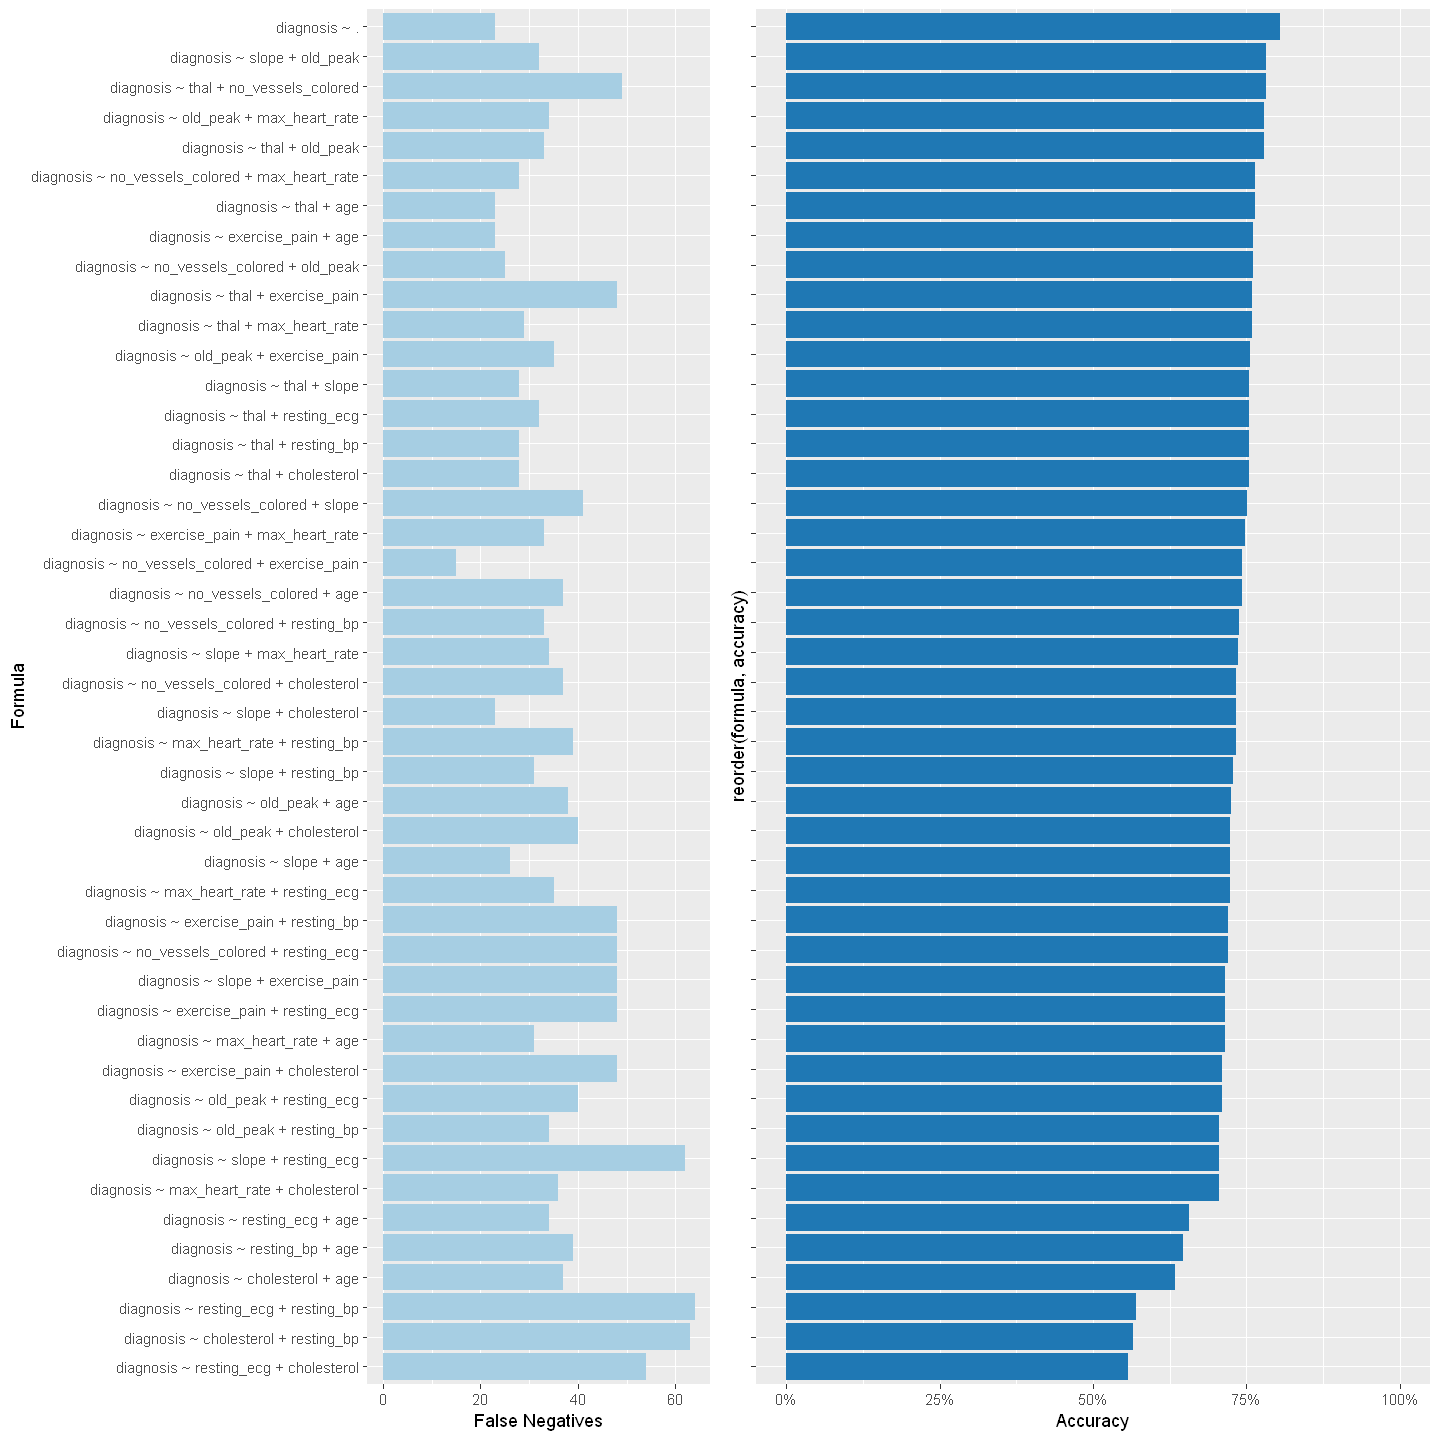

In [17]:
plot_acc <- two_predictors %>%
    ggplot(aes(x = accuracy, y = reorder(formula, accuracy))) +
    geom_bar(stat = "identity", fill = "#1f78b4") +
    scale_x_continuous(labels = scales::percent,
                       limits = c(0, 1)) +
    labs(x = "Accuracy") +
    theme(axis.text.y = element_blank())

plot_false <- two_predictors %>% 
    ggplot(aes(x = false_healthy, y = reorder(formula, accuracy))) +
    geom_bar(stat = "identity", fill = "#a6cee3") +
    labs(x = "False Negatives", y = "Formula")

options(repr.plot.width = 12, repr.plot.height = 12)
plot_grid(plot_false, plot_acc, ncol = 2)

<span style="color: gray;">Figure 3. The (a) False Negatives value and (b) Accuracy percentage of different combinations of predictors</span>

### Model Selection & Verification

We now have to select the formula we want to use.

For this, we mostly want high accuracy. If the accuracy is comparable, we want to make sure to choose the one with fewer false negatives. As we are aiming for a simple check-up, using all predictors (`diagnosis ~ .`) is not ideal, though yielding the highest accuracy. We pick `exercise_pain + age` because it has similar false negatives while having an accuracy that is similar to when using all predictors while being attributes that are easily examined.

In [18]:
two_predictors %>% filter(formula == "diagnosis ~ ." |
                          formula == "diagnosis ~ exercise_pain + age")

formula,k,accuracy,false_healthy
<chr>,<dbl>,<dbl>,<dbl>
diagnosis ~ .,13,0.8053113,23
diagnosis ~ exercise_pain + age,17,0.7606695,23


<span style="color: gray;">Table 8. The accuracy results for the selected formula, compared with the "all predictors" version</span>

The chosen model uses the number of vessels colored and maximum heart rate as predictors. Exercise pain can be evaluated by the patient doing exercises suggested by the doctor and recording any pain that has emerged. Furthermore, there is a very useful tool that doctors use called the exercise electrocardiogram. This can be done to determine the stress on the heart caused by exercising (Heart and Stroke Foundation of Canada, n.d.).

We can now verify the model on the testing data.

In [19]:
clev_numeric <- transform_numeric(cleveland)

In [20]:
image_recipe <- recipe(diagnosis ~ exercise_pain + age, data = training_set) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
       set_engine("kknn") %>%
       set_mode("classification")

knn_fit <- workflow() %>%
       add_recipe(image_recipe) %>%
       add_model(knn_spec) %>%
       fit(data=training_set)

In [21]:
testing_set <- testing_set %>% na.omit()

predictions <- predict(knn_fit, testing_set) %>%
    bind_cols(testing_set)

final_quality <- predictions %>%
    metrics(truth = diagnosis, estimate = .pred_class) %>% 
    filter(.metric == "accuracy")

predictions %>% conf_mat(truth = diagnosis, estimate = .pred_class)

final_quality

          Truth
Prediction healthy sick
   healthy      28   11
   sick         13   23

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.68


<span style="color: gray;">Table 9. The accuracy results and confusion matrix for <tt> exercise_pain and age </tt></span>

Overall, the accuracy for our model is 68%, which is much lower than expected. This could have been due to only taking into account 2 predictor variables and randomization during the splitting process.

Using this version, the rate for diagnosing sick patients as healthy is ~34%. This means that 3 out of 10 cases of heart disease are misdiagnosed. However, as this is a simple method for doctors to use as a signal to further monitor patients for risk of developing disease, the accuracy for this version may be acceptable.

We can also plot the whole data set and the areas where new data points will be classified as sick or healthy (Figure 4).

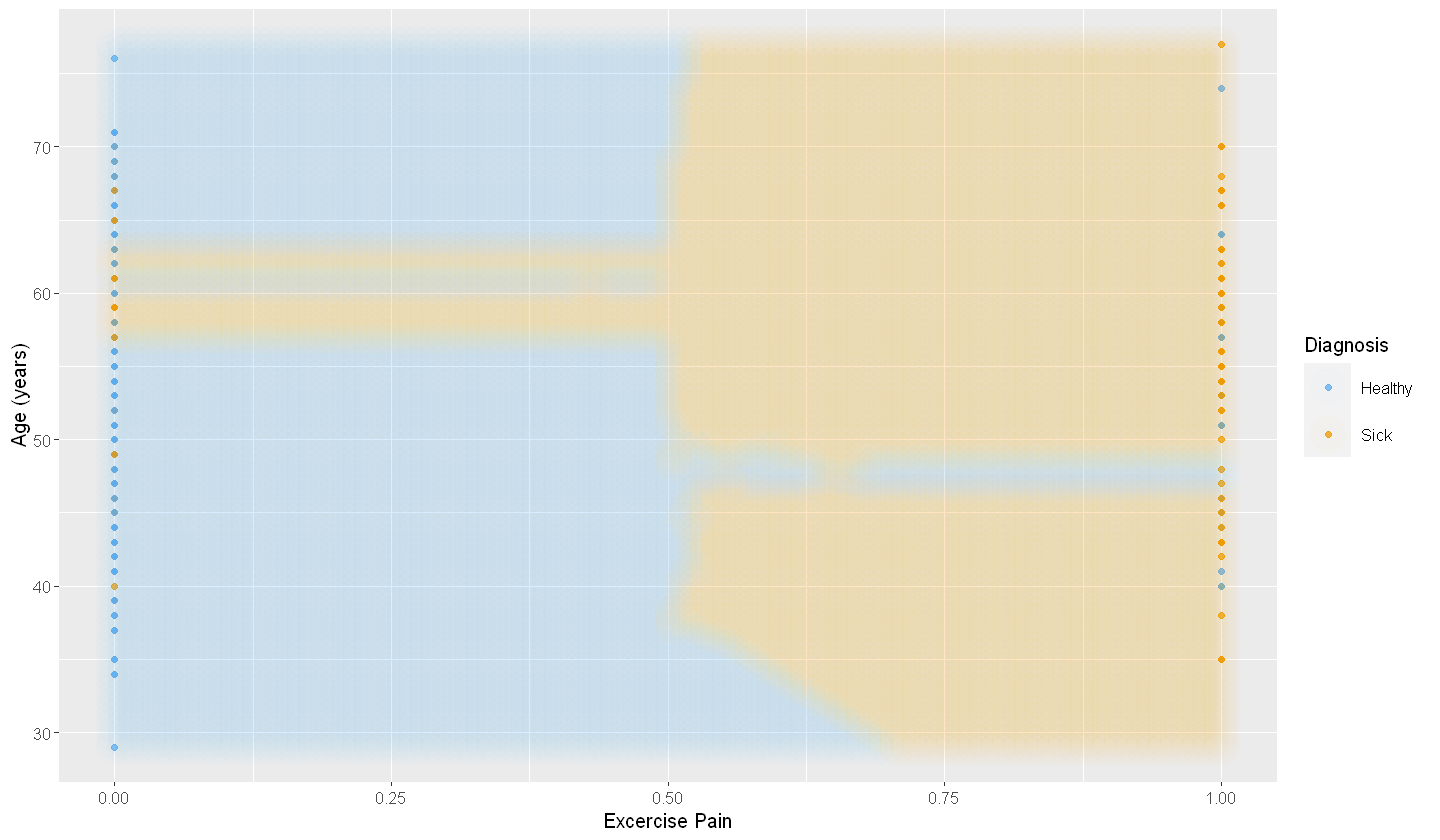

In [22]:
options(repr.plot.width = 12, repr.plot.height = 7) 

# create the grid of area/smoothness vals, and arrange in a data frame
# Code taken and adapted from https://datasciencebook.ca/classification.html#fig:05-upsample-plot
x_grid <- seq(min(clev_numeric$exercise_pain, na.rm = TRUE),
                max(clev_numeric$exercise_pain, na.rm = TRUE),
                length.out = 100)

y_grid <- seq(min(clev_numeric$age),
                max(clev_numeric$age),
                length.out = 100)

ex_age_grid <- as_tibble(expand.grid(exercise_pain = x_grid,
                                age = y_grid))

# use the fit workflow to make predictions at the grid points
knn_pred <- predict(knn_fit, ex_age_grid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knn_pred, ex_age_grid) %>% 
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = clev_numeric, 
             mapping = aes(x = exercise_pain, 
                           y = age, 
                           color = diagnosis), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = exercise_pain, 
                           y = age, 
                           color = Class), 
             alpha = 0.02, 
             size = 10) +
  labs(color = "Diagnosis", 
       x = "Excercise Pain", 
       y = "Age (years)") +
  scale_color_manual(labels = c("Healthy", "Sick"), 
                     values = c("steelblue2", "orange2")) +
  theme(text = element_text(size = 12))

wkflw_plot

<span style="color: gray;">Figure 4. Fitting of data with <tt> exercise pain and age </tt> as predictors</span>

Figure 4 suggests that having any exercise-induced pain is more likely to be classified as sick regardless of age. However, the rigged areas in the graph suggests that there might have been outliers, confounding variables and/or over-fitting of the KNN model since we are not taking into considerations other factors that are highly interrelated to age or exercise pain. 

A research paper (Niederstrasser & Attridge, 2022) shows that older adults have a higher incidence of musculoskeletal pain especially chronic pain and are generally less physically active than younger adults. However, the main reason is not due to aging but low physical activity and low wealth during their younger age. Another research (Ciolac, Brech & Greve, 2010) suggests that age does not affect the musculoskeletal and cardiovascular response to resistance and aerobic training in women. The elderly can exercise safely while having similar exercise intensity compared with the younger and the workload progression does not increase the risk of muscle incidence or injuries. In conclusion, both articles we found suggest that age does not directly affects exercise pain.

## Discussion

This analysis challenges some of the initial research done for this project.  For example, cholesterol is typically considered highly correlated with heart disease (2), however it appears not to be a strong predictor in this data set (Figure 3); there is not a significant distribution difference between the sick and healthy population (Figure 2a). On the other hand, exercise pain is a pretty good predictor for heart disease in this data set, which makes sense from a naive standpoint, as well as from the distribution of the data set (cf. Figure 1).

Beginning this project, we were optimistic about finding a model with high accuracy that could be used to predict heart disease. However, the highest accuracy found during this analysis was around 80%. Ideally, this analysis would have revealed a set of predictors with an even higher accuracy. This might be due to confounding variables, the slight imbalance (cf. Figure 4) and outliers within our data set.

Our model offers a preliminary diagnosis, which helps healthcare professional to save time and medical costs when identifying high-risks population. Hence, age and exercise pain are appropriate predictors for this purpose as it is inexpensive, time-efficient and require minimal testing. Despite being a preliminary diagnosis tool for heart diseases, improvements such as taking confounding variables into account and/or using a bigger data set in future projects would help improve the model"s accuracy.

There are several open questions: Can our model be improved to diagnose the severity of heart disease in patients? Are we able to improve our accuracy and false negative rate by taking more predictors? Are there predictors that are less expensive but still achieve a similar accuracy? In our data set, most formulas with high accuracy involve expensive tests (cf. Figure 3). Lastly, is there a more effective and convenient predictor for diagnosing heart disease than the ones used in this analysis? One example for this might be a family history of heart diseases (American Heart Association, 2015).

## References


Ahmad, F. B., & Anderson, R. N. (2021). The leading causes of death in the US for 2020. JAMA, 325(18). https://doi.org/10.1001/jama.2021.5469

American Heart Association. (2015). Family History and Heart Disease, Stroke. Www.heart.org. https://www.heart.org/en/health-topics/consumer-healthcare/what-is-cardiovascular-disease/family-history-and-heart-disease-stroke

Centers for Disease Control and Prevention. (2022, October 14). Heart disease Facts. Centers for Disease Control and Prevention. https://www.cdc.gov/heartdisease/facts.htm

Ciolac, E. G., Brech, G. C., & Greve, J. M. (2010). Age does not affect exercise intensity progression among women. Journal of strength and conditioning research, 24(11), 3023–3031. https://doi.org/10.1519/JSC.0b013e3181d09ef6

Detrano, R. (1988). Heart Disease Data Set. UC Irvine Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Heart and Stroke Foundation of Canada. (n.d.). Exercise Electrocardiogram. Heart and Stroke Foundation of Canada. https://www.heartandstroke.ca/heart-disease/tests/exercise-electrocardiogram

Madjid, M., Safavi-Naeini, P., Solomon, S. D., & Vardeny, O. (2020). Potential Effects of Coronaviruses on the Cardiovascular System: A Review. JAMA Cardiology, 5(7). https://doi.org/10.1001/jamacardio.2020.1286

National Heart, Lung, and Blood Institute. (2022, March 24). Angina (Chest Pain) - Types | NHLBI, NIH. Www.nhlbi.nih.gov. https://www.nhlbi.nih.gov/health/angina/types#:~:text=The%20types%20of%20angina%20are

Niederstrasser, N. G., & Attridge, N. (2022). Associations between pain and physical activity among older adults. PloS one, 17(1), e0263356. https://doi.org/10.1371/journal.pone.0263356

Timbers, T., Campbell, T., & Lee, M. (2022). Data Science: A First Introduction. In datasciencebook.ca (1st ed.). Chapman & Hall. https://datasciencebook.ca/
